---

# Introdução e Classificação Simples

Neste laboratório você irá realizar algumas operações básicas com imagens (leitura e manipulações); você programará um classificador entre cães e gatos manualmente; e, você também usará o framework do FastAI para treinar uma rede neural profunda nesse mesmo problema.

Além das questões avaliadas, acrescentamos também um problema que nos deparamos a fazer a aula e que não tivemos tempo de resolver: o problema do blend dos canais de cores das 3 imagens da capivara no Google Slides.

In [4]:
# from pathlib import Path             # Já importado pelo fastai
# from typing import Callable          # Já importado pelo fastai
# import numpy as np                   # Já importado pelo fastai
# import pandas as pd                  # Já importado pelo fastai
# from PIL import Image                # Já importado pelo fastai
# from matplotlib import pyplot as plt # Já importado pelo fastai
from fastai.vision.all import *
import cv2



# Caso esteja executando o notebook localmente, reimplementa o cv2_imshow
from IPython.utils import io
from IPython.display import display
import warnings
try:
    from google.colab.patches import cv2_imshow
except:
    def cv2_imshow(img):
        display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# Faz o numpy imprimir mais números por linha
np.set_printoptions(edgeitems=40, linewidth=130)

In [5]:
# Verifica se já foram baixadas as imagens do drive, baixando-as e descompactando se necessário
! [ ! -d "/content/cats_vs_dogs" ] && gdown -O /content/cats_vs_dogs.zip "1VuxwfbLZDXPt_0yKTauh4LRIhqMX1SdR" &&  unzip -q /content/cats_vs_dogs.zip -d /content && rm /content/cats_vs_dogs.zip

base_path = Path("/content/cats_vs_dogs")

## Operações Básicas

### Leitura e Visualização de uma imagem (apenas ilustrativo)

Vamos carregar algumas imagens aqui, fique livre para escolher qualquer imagem:

(escolhemos filhotes por serem mais ditáticos ...)

In [6]:
caminho_imagem_cat = str(base_path/'train'/'cat'/'00125.jpg')
caminho_imagem_dog = str(base_path/'train'/'dog'/'00042.jpg')
caminho_imagem_cat, caminho_imagem_dog

('/content/cats_vs_dogs/train/cat/00125.jpg',
 '/content/cats_vs_dogs/train/dog/00042.jpg')

Vamos carregar uma imagem usando o Pillow, por meio da função `Image.open`:

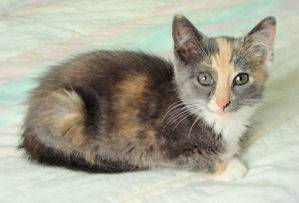

In [7]:
img_pillow = Image.open(caminho_imagem_cat)
img_pillow

A imagem Pillow é um objeto próprio dela, mas pode ser convertido para uma matriz numpy por meio do casting `np.array(img_pillow)`

In [8]:
type(img_pillow)

PIL.JpegImagePlugin.JpegImageFile

Vamos carregar uma imagem usando o OpenCV, para isso usamos a função `cv2.imread`. Já para exibi-la, no Colab usamos o cv2_imshow (mas no notebook local acaba sendo o próprio PIL):

Perceba também que o tipo da imagem que o OpenCV retorna já é uma matriz numpy (`numpy.ndarray`)

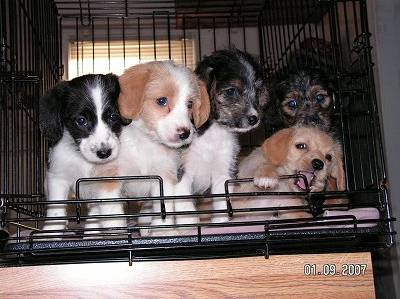

numpy.ndarray

In [9]:
img_opencv = cv2.imread(caminho_imagem_dog)
cv2_imshow(img_opencv)
type(img_opencv)

Vamos observar os pixels da Imagem no formato de tabela (planilha), vamos carregar uma imagem de um gato menor (subamostrada e só com um canal).

Perceba que a subamostragem foi realizado da forma mais rápida (bronca) possível: usando stepping `::2`. Em vez de calcular a média do 2x2 pixels, nós só pegamos o valor de 1 que está no topo esquerdo desse 2x2, isso é, começando do índice zero e pegando o próximo a 2 (índices pares).

Vamos usar a biblioteca Pandas, para fazer uma exibição tipo planilha.

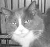

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,142,147,159,159,114,120,117,152,159,164,167,65,117,170,178,174,177,166,108,173,201,177,193,199,84,118,201,205,213,217,216,87,193,189,155,165,210,177,103,194,204,128,203,198,115,112,200,181,184,183
1,142,148,159,163,121,111,116,154,161,163,167,64,115,168,176,173,177,164,107,170,198,180,195,193,73,124,194,191,199,204,197,91,143,112,108,115,189,172,99,201,202,124,199,197,110,115,197,178,182,181
2,138,148,154,167,133,102,119,152,162,161,168,64,114,164,172,172,177,160,105,164,191,180,191,185,70,126,183,192,198,207,187,118,106,130,149,109,181,166,97,200,196,121,192,195,102,120,194,174,180,179
3,134,145,149,166,142,97,124,145,161,158,169,64,111,161,169,171,176,158,105,159,184,174,183,180,72,126,181,188,195,187,159,92,125,147,156,127,181,147,95,188,191,117,185,192,96,125,189,169,176,176
4,140,154,148,153,149,101,118,137,161,152,167,75,104,170,169,163,177,155,88,166,189,176,178,167,77,132,176,196,189,160,86,110,135,155,164,108,126,112,83,185,195,103,173,194,94,133,183,178,171,174
5,140,150,154,154,155,97,116,132,162,151,166,73,106,163,170,162,176,154,87,159,181,176,182,175,75,120,175,189,177,93,102,135,157,150,167,112,95,81,72,176,191,103,174,192,87,133,180,174,170,170
6,139,155,149,154,139,83,124,115,161,151,165,70,103,156,167,160,167,149,90,157,175,172,173,169,91,121,164,165,116,87,128,143,161,158,159,122,97,83,84,178,183,101,172,187,77,134,174,168,160,154
7,138,121,120,134,147,108,117,119,161,150,163,68,94,157,162,157,166,148,93,154,174,161,147,142,123,145,144,135,91,114,142,155,168,163,145,119,90,87,85,172,177,100,171,185,71,138,172,167,150,138
8,136,97,123,116,102,120,120,136,149,152,161,72,106,162,155,159,155,141,119,130,126,125,138,142,133,142,125,97,96,127,135,160,155,170,159,129,114,99,97,172,173,105,167,191,64,130,163,153,119,102
9,120,111,136,136,122,111,100,107,125,152,163,94,122,157,151,142,142,137,121,121,122,134,151,136,123,114,95,85,109,136,141,148,178,147,137,103,111,123,122,159,163,103,164,186,66,139,155,122,97,88


In [10]:
pequeno_gato = cv2.imread(str(base_path/'train'/'cat'/'00216.jpg'))[::2, ::2, 1]
cv2_imshow(pequeno_gato)
df = pd.DataFrame(pequeno_gato)
df.style.set_properties(**{'font-size':'7pt'}).background_gradient('gray', axis=None, vmin=0, vmax=255)

Vamos ver a imagem no formato de 'função' matemática, nesse plot de grids acaba sendo uma simples função que interpola linearmente os pontos:

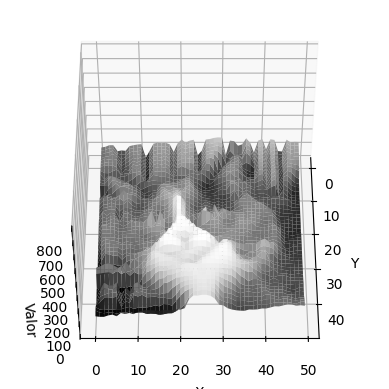

In [11]:
image_array = pequeno_gato.astype('float64')

x = np.arange(image_array.shape[1])
y = np.arange(image_array.shape[0])
x, y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(y, x, image_array, cmap='gray', rcount=image_array.shape[0], ccount=image_array.shape[1])
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Valor')
ax.set_zlim(0, 800) # MUDE ISSO PARA VER A ESCALA

# MUDE ISSO PARA VER DE OUTRO ANGULO
ax.view_init(50, 0)

plt.show() # Exibe o plot

Olha o que acontece quando trocamos o formato do OpenCV (BGR) pelo o do Pillow (RGB):

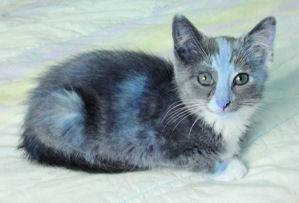

In [12]:
cv2_imshow(np.array(img_pillow))

O Matplotlib também tem a mesma convenção do RGB que o Pillow, e usa a função `imshow`:

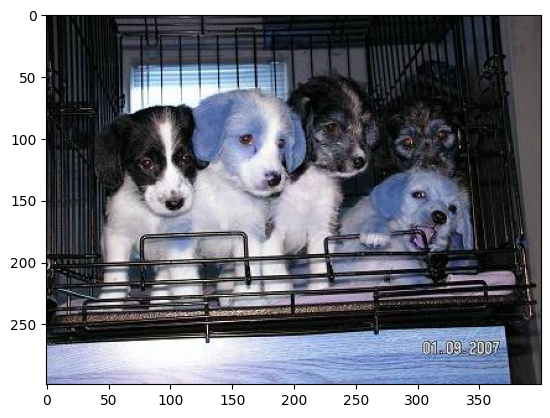

In [13]:
plt.figure()
plt.imshow(img_opencv)

Enquanto o Pillow, dentro do Jupyter notebook, mostra a imagem na sua resolução original (e em um formato PNG), o Matplotlib altera a resolução da imagem de acordo com a resolução (DPI) do plot, realizando um redimensionamento contínuo da imagem.

Veja inclusive que ele coloca uma escala de `x` e `y` em pixels, e trata a imagem como se fosse uma função.

### Converter entre BGR e RGB

**Explicação sobre o assunto**

Então você deve ter percebido que trocar o canal vermelho pelo azul, deixa a imagem com uma percepção de cor completamente diferente. A cor da pele das pessoas tende a ficar azul, mas em certas imagens também pode ser pouco perceptível que as cores estão trocadas, então tem que ficar atento no próprio código!

In [14]:
def converte_BGR_RGB(imagem: np.ndarray):
    """ Recebe uma imagem no formato BGR ou RGB e converte para o outro formato.
    :param imagem: imagem com shape (H, W, 3) d
    Retorna uma nova imagem convertida (não é para modificar a imagem original).
    """

    imagem_convertida = imagem[:,:, [2, 1, 0]]
    return imagem_convertida

Veja, agora a cor deve ficar correta:

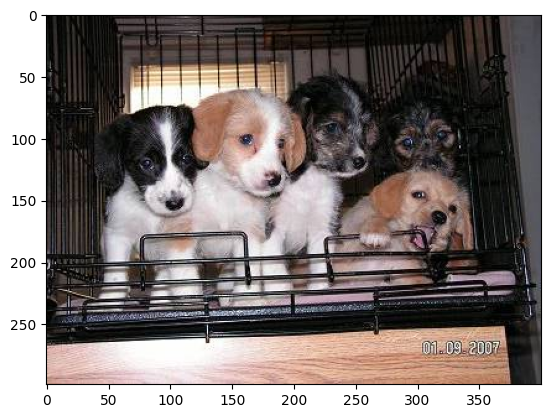

In [15]:
plt.imshow(converte_BGR_RGB(img_opencv))

### Converter de RGB para *grayscale*

**Explicação sobre o assunto**

Para cada pixel da imagem $I(y, x)$ formada pelos canais azul $B(y, x)$, verde $G(y, x)$ e vermelho $R(y, x)$, na convenção do OpenCV $I(y, x) = \left(B(y, x), G(y, x), R(y, x)\right)$ aplicamos uma transformação linear a cada um desses canais para obter um novo canal de cinza $C(y, x)$. Essa transformação é aplicada a cada pixel $(y, x)$ da imagem:

$C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x)$.

Esses coeficientes dependem da sensibilidade do sensor e do meio de exibição (tela) de acordo com a percepção humana. Os coeficientes acimas são para imagens digitais de acordo com a especificação ITU BT.601.

Nota: essa transformação só vale para espaços lineares, quando os valores de cada pixel da imagem não está representada como um resultado de uma exponenciação pelo coeficiente gama $\gamma$: $I_\text{não linear}(y, x) = I(y, x)^\gamma$. Caso a imagem não esteja representada linearmente, é necessário fazer a tranformação inversa dessa exponenciação por gama.

Nos labs vamos sempre assumir que já está no espaço linear (apesar de provavelmente isso não ser verdade, pelo fato de serem imagens de câmeras).

In [16]:
# questao_grayscale

def converte_BGR_para_cinza(imagem_BGR: np.ndarray):
    """
    Implemente a sua própria função que converte uma imagem colorida de três canais BGR (blue, green, red) para
    escala de Cinza C conforme a equação C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x) aplicada em cada
    pixel (y, x).
    :param imagem_BGR: Matriz (H, W, 3) que representa a imagem de altura H, largura W e 3 canais de cores BGR
    Retorna uma nova imagem resultante (H, W) em escala de cinza no formato de 8-bits positivos.
    Utilize truncamento para aproximar o resultado intermediário que seria em ponto flutuante (para correção)
    """

    imagem_cinza = (imagem_BGR[:,:, 0]*0.114+imagem_BGR[:,:, 1]*0.587+imagem_BGR[:,:, 2]*0.299).astype(np.uint8)
    return imagem_cinza

Vejamos o resultado em uma imagem:

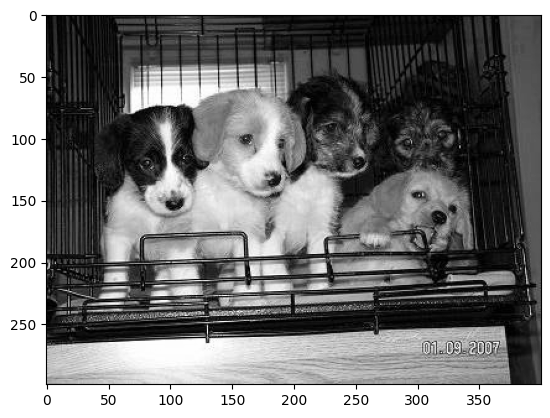

In [17]:
plt.imshow(converte_BGR_para_cinza(img_opencv), cmap='gray', vmin=0, vmax=255)

Agora você poderia fazer um plot com o matplotlib, sem passar o argumento do `cmap` e achar que a imagem ainda está colorida. Mas não é isso que está acontecendo. Lembra que o matplotlib interpreta a imagem como se fosse uma função matemática? Ele utiliza uma escala de cor (colormap, que lembra um mapa de calor) e associa o valor da função em um ponto a uma cor.

O padrão dele (`None`) é o `viridis` que vai do azul escuro ao amarelo claro, na figura anterior usamos o `gray` que vai do preto para o branco, tem também o `Greys` que vai do branco para o pretor e muitas outras escalas de cor, `plasma`, `inferno`, `rainbow` e [muito mais](https://matplotlib.org/stable/tutorials/colors/colormaps.html):

### Luminosidade Média da imagem

**Explicação sobre o assunto**

Uma das features mais simples de se obter de uma imagem é justamente com relação à sua cor, isto é, a cor média de uma imagem inteira, seja sobre em seus canais R, G ou B ou ainda de sua luminosidade Y.

Uma intuição sobre isso seria: caso a imagem fosse reduzida a apenas um pixel (você estivesse olhando de muito longe) qual a cor / luminosidade que você enxergaria?

In [18]:
# questao_luminosidade

def luminosidade_media(imagem: np.ndarray):
    """
    :param imagem: Matriz numpy (H, W) ou (H, W, 3) BGR que representa uma imagem
    Retorna uma nova imagem convertida (não é para modificar a imagem original).
    """

    if ( len(imagem.shape) == 3): #color
      imagem = converte_BGR_para_cinza(imagem)

    luminosidade_media = np.mean(imagem[:])
    return luminosidade_media

Vejamos a luminosidade média de algumas imagens:

In [19]:
luminosidade_media(img_opencv), luminosidade_media(np.array(img_pillow))

(93.08232441471571, 161.21109774782937)

### Calcular Histograma

**Explicação sobre o assunto**

Uma forma interessante de analisar a iluminação é verificar a distribuição dos valores de cada pixel na imagem, isto é, construir um histograma. Geralmente ele é aplicado em cada canal de cores separadamente, ou ainda na imagem em escala de cinza.

Isso já é um 'avanço' sobre a cor média de uma imagem, pois no lugar de gerar apenas uma feature (média), geramos uma distribuição de features (256).

Assim para construir um histograma, basta contar quantos pixels tem um determinado valor, que no caso das imagens de 8 bits, são valores que estão entre 0 e 255 (inclusive).

In [20]:
# questao_histograma

def distribuicao(imagem_mono: np.ndarray):
    """
    Implemente a sua própria função que realiza a contagem do valor de cada pixel.
    :param imagem_mono: Matriz (H, W) imagem de altura H, largura W
    Retorna um vetor (v) com a contagem (q) dos valores de intensidade luminosa (i) da imagem v[i] = q.
    """
    contagem = np.zeros(256, dtype=np.uint64)


    for i in range(256):
      contagem[i] = len(imagem_mono[ imagem_mono == i])

    return contagem

Visualizando essa contagem em um gráfico de barras:

<BarContainer object of 256 artists>

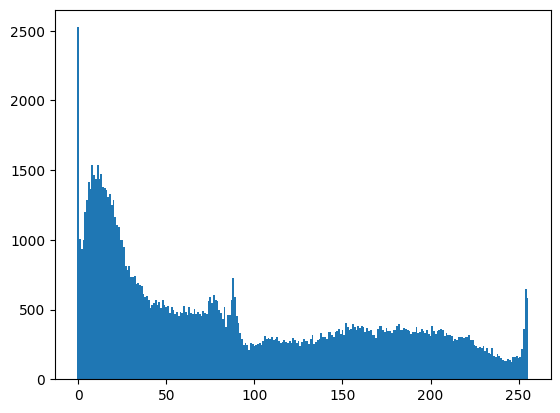

In [21]:
canal_verde = img_opencv[:, :, 1]
plt.bar(np.arange(256), distribuicao(canal_verde), width=1)

O matplotlib também já tem uma função `plt.hist` que já realiza automaticamente o cálculo desse histograma (de um vetor unidirecional). Para isso temos que transformar uma matriz em um vetor que é a concatenação das linhas, como se desenrolássemos a sequência de pixels da matrix `matrix.ravel()` ou `.flatten()`. Só atente para colocar a quantidade de bins entre 0 e 255:

array([2525., 1004.,  934., 1002., 1200., 1287., 1413., 1364., 1536., 1468., 1438., 1535., 1439., 1471., 1376., 1370., 1360.,
       1307., 1332., 1249., 1285., 1163., 1109., 1093., 1001.,  999.,  947.,  814.,  786.,  810.,  737.,  737.,  739.,  687.,
        691.,  676.,  672.,  612.,  589.,  600.])

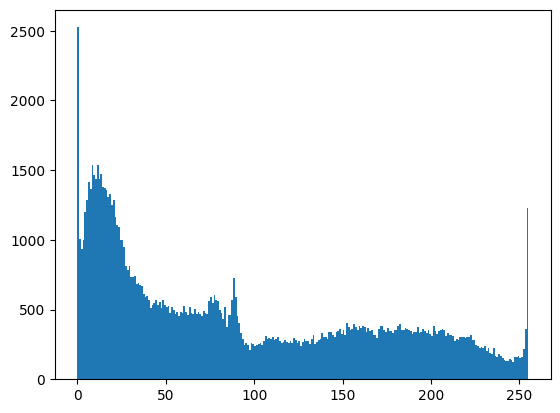

In [22]:
n, bins, patches = plt.hist(canal_verde.ravel(), bins=np.arange(256))
n[:40] # Olhando o valor dos 40 primeiros elementos que ele conta

Normalmente, os histogramas podem ser normalizados, de forma que o somatório dos valores dos bins seja igual a 1. Dessa forma teríamos uma densidade de probabilidade (no caso discreto é a própria probabilidade de amostrar o valor daquele bin).

Histogramas são bons não apenas para visualizar a distribuição da 'cor' dos pixels em uma imagem, mas também podem ser utilizado para visualizar as 'features' de um dataset.

## Classificação Baseada em Regras

**Explicação sobre o assunto**

Agora é um dos ápices desse lab, tudo anteriormente foi um aquecimento para chegarmos aqui. Com base nas funções desenvolvidas anteriormente (nem todas) selecione as *features*, isto é, características (uma função matemática dos números) que consiga distinguir entre imagens de gatos e de cachorros para o dataset apresentado. Assim, quando você encontrar essa(s) característica(s) da imagem que sejam diferentes, você consegue escrever uma função classificadora, que vai estimar se a imagem é de gato ou cachorro. No caso, você também vai ter que definir esse valor de limiar de classificação da feature manualmente.

Vamos carregar manualmente as primeiras 100 imagens do conjunto de treinamento para gatos e cachorros, além de definir uma função que você pode usar para rodar em todo o dataset de treino / validação (os profs ainda podem ter outro dataset de teste que vocês não tem acesso, mas que vem da mesma distribuição):

In [23]:
cats = [cv2.imread(str(p)) for p in (base_path/'train'/'cat').glob('000*.jpg')]
dogs = [cv2.imread(str(p)) for p in (base_path/'train'/'dog').glob('000*.jpg')]

def avalia_classificador(funcao_classificadora: Callable[[np.ndarray], bool], dataset: Path):
    cats = [funcao_classificadora(cv2.imread(str(p))) for p in (dataset/'cat').glob('000*.jpg')]
    dogs = [not funcao_classificadora(cv2.imread(str(p))) for p in (dataset/'dog').glob('000*.jpg')]
    return np.mean(cats + dogs)

#avalia_classificador(classificador_classico, base_path/'train') # roda assim

Você também pode visualizar as imagens do dataset para ter um 'feeling' melhor de como fazer o seu classificador manual:

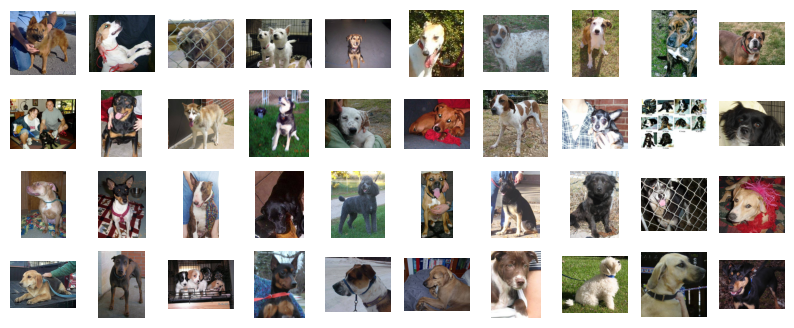

In [24]:
fig, axs = plt.subplots(4, 10, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(converte_BGR_RGB(dogs[i])) # ou cats
    ax.axis('off')
plt.show()

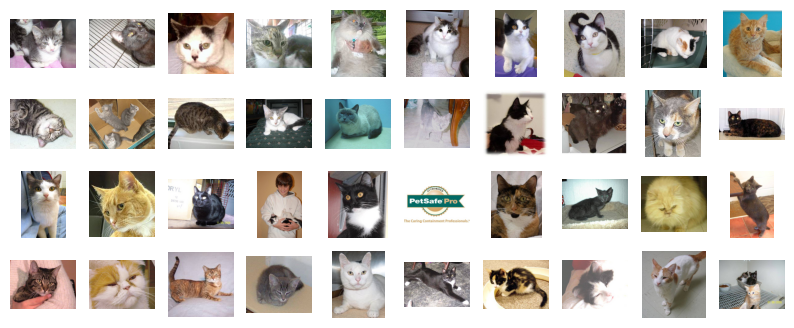

In [25]:
fig, axs = plt.subplots(4, 10, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(converte_BGR_RGB(cats[i])) # ou cats
    ax.axis('off')
plt.show()

**Enunciado da Questão**

Agora implemente a função `classificador_classico` que recebe uma imagem e retorna se é gato ou cachorro. Para passar no teste tem que ter pelo menos 80% de acurária (total) e pelo menos 75% de precisão em cada classe.

Para alegria de todos, você pode usar LLM e pesquisas na internet para resolver essa questão. Se usar LLM, por gentileza, escreva os prompts que usou e o modelo para nós podermos aprender também o prompt engineering que você utilizou.

<details><summary><b>Dica</b></summary>
<p>
As questões todas do lab foram preparadas já como dica para essa questão, usa as funções que você implementou e também tem uma história no final do lab que pode motivá-lo. A solução que pensamos e implementamos é extremamente simples.
</p>
</details>

In [26]:
# questao_classica

def classificador_classico(imagem: np.ndarray):
    """Classifica se uma imagem é de um gato ou de um cachorro.
    :param imagem: Matriz numpy (H, W, 3) que representa uma imagem BGR.
    Retorna True se a imagem for de um gato ou False se for de um cachorro.
    """

    i = luminosidade_media(imagem)

    return i >= 120 #valor um pouco abaixo da média (dos gatos) para tomada de decisao com forte viés.

Veja como fica a matriz de confusão:

In [32]:
# testa_classica

resposta_cat = np.array([classificador_classico(img) for img in cats])
resposta_dog = np.array([classificador_classico(img) for img in dogs])

precisao_cat = np.mean(resposta_cat)
precisao_dog = np.mean(~resposta_dog)
acuracia = np.mean(np.concatenate([resposta_cat, ~resposta_dog]))
assert precisao_cat > 0.75
assert precisao_dog > 0.75
assert acuracia > 0.8

In [33]:
def cria_matrix_confusao(resposta_cat, resposta_dog):
    classificacao_verdadeira = [True]*len(resposta_cat) + [False]*len(resposta_dog)
    classificacao_predita = np.concatenate([resposta_cat, resposta_dog])
    conf = pd.crosstab(classificacao_verdadeira, classificacao_predita)
    conf.index = ['Dog Verdade', 'Cat Verdade']
    conf.columns = ['Dog Predito', 'Cat Predito']
    return conf
m = cria_matrix_confusao(resposta_cat, resposta_dog)
m

,Dog Predito,Cat Predito
Dog Verdade,81,19
Cat Verdade,15,85


In [34]:
(m['Dog Predito']['Dog Verdade'] + m['Cat Predito']['Cat Verdade'])/m.sum().sum()

0.83

Agora tente baixar algumas imagens de gatos e cachorros e veja como o seu classificador se comporta (ou então veja na pasta `fora_distribuicao`):

In [30]:
m = cria_matrix_confusao(*[np.array([classificador_classico(cv2.imread(str(p)))
                          for p in (base_path/'fora_distribuicao'/animal).glob('*.jpg')]) for animal in ['cat', 'dog']])
m

,Dog Predito,Cat Predito
Dog Verdade,19,31
Cat Verdade,32,16


In [31]:
(m['Dog Predito']['Dog Verdade'] + m['Cat Predito']['Cat Verdade'])/m.sum().sum()

0.35714285714285715